In [ ]:
pip install pydicom nibabel numpy torch torchvision segmentation-models-pytorch scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install albumentations

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import numpy as np
import pydicom
import nibabel as nib
import torch
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import pandas as pd
import random
import segmentation_models_pytorch as smp
import torch.optim as optim
import torch.nn as nn
from scipy.ndimage import zoom
from operator import itemgetter
from sklearn.metrics import jaccard_score


random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
num_classes = 9
batch_size = 8
img_root = "/home/ealam/JHIR_Hip_Knee_Datasets/Knee/Images"
mask_root = "/home/ealam/JHIR_Hip_Knee_Datasets/Knee/Annotations"
metadata_path = "/home/ealam/JHIR_Hip_Knee_Datasets/Knee/segmentation_with_racegender.csv"
test_augmentations = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2(),
])

class MulticlassHipSegmentationDataset(Dataset):
    def __init__(self, img_root, mask_root, metadata_df, image_files, mask_files, num_classes, transforms=None, preprocessing=None):
        self.img_root = img_root
        self.mask_root = mask_root
        self.metadata_df = metadata_df
        self.img_files = image_files
        self.mask_files = mask_files
        self.num_classes = num_classes
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        dicom_image = pydicom.dcmread(os.path.join(self.img_root, self.img_files[int(float(idx))]))
        image = dicom_image.pixel_array.astype(np.float32)
        annotation = nib.load(os.path.join(self.mask_root, self.mask_files[int(float(idx))]))
        annotation_data = annotation.get_fdata()
        if len(annotation_data.shape) == 3:
            annotation_data = annotation_data[:, :, 0]

        annotation_data = self.calculate_flipped_rotated_mask(annotation_data)

        if annotation_data.ndim > 2 and annotation_data.shape[-1] != 1:
            raise ValueError('Mask has multiple channels')

        if image.shape != annotation_data.shape:
            zoom_factors = np.array(image.shape) / np.array(annotation_data.shape)
            annotation_data = zoom(annotation_data, zoom_factors, order=0)

        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=annotation_data)
            image = transformed["image"]
            annotation_data = transformed["mask"]

        annotation_data_onehot = self.one_hot_encode(annotation_data)

        if self.preprocessing is not None:
            transformed = self.preprocessing(image=image, mask=annotation_data_onehot)
            image = transformed["image"]
            annotation_data_onehot = transformed["mask"]

        patient_id = int(float(self.img_files[int(float(idx))].split(".")[0]))
        racegender_info = self.metadata_df.loc[self.metadata_df['id'] == patient_id]['racegender'].values
        racegender = racegender_info[0] if racegender_info else 'Unknown'

        return image, annotation_data_onehot, racegender

    def one_hot_encode(self, mask):
        one_hot_mask = np.zeros((self.num_classes, *mask.shape), dtype=np.float32)
        for class_idx in range(self.num_classes):
            one_hot_mask[class_idx][mask == class_idx] = 1.0
        return one_hot_mask

    def calculate_flipped_rotated_mask(self, mask):
        rotated_mask = cv2.rotate(mask, cv2.ROTATE_90_CLOCKWISE)
        flipped_rotated_mask = cv2.flip(rotated_mask, 1)
        return flipped_rotated_mask

metadata_df = pd.read_csv(metadata_path)

image_files = sorted(os.listdir(img_root))
mask_files = sorted(os.listdir(mask_root))
paired_files = list(zip(image_files, mask_files))
random.shuffle(paired_files)

train_size = int(0.2 * len(paired_files))
valid_size = int(0.1 * len(paired_files))
test_size = len(paired_files) - train_size - valid_size

train_pairs = paired_files[:train_size]
valid_pairs = paired_files[train_size:train_size + valid_size]
test_pairs = paired_files[train_size + valid_size:]


train_set = MulticlassHipSegmentationDataset(
    img_root, mask_root, metadata_df, [p[0] for p in train_pairs], [p[1] for p in train_pairs], num_classes,
    transforms=test_augmentations
)


model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=1,
    classes=num_classes,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()


valid_set = MulticlassHipSegmentationDataset(
    img_root, mask_root, metadata_df, [p[0] for p in valid_pairs], [p[1] for p in valid_pairs], num_classes,
    transforms=test_augmentations
)

valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=2)


num_epochs = 100
increment_percentage = 0.1

for epoch in range(num_epochs):
    if epoch == 0:
        train_size = int(0.2 * len(paired_files))
    else:
        train_size += int(increment_percentage * len(paired_files))
        if train_size > len(paired_files):
            train_size = len(paired_files)
    train_pairs = paired_files[:train_size]

    train_set = MulticlassHipSegmentationDataset(
        img_root, mask_root, metadata_df, [p[0] for p in train_pairs], [p[1] for p in train_pairs], num_classes,
        transforms=test_augmentations
    )

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)


    model.train()

    iou_racegender_list = []

    for batch_idx, (images, masks, racegender) in enumerate(train_loader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        predicted_masks = torch.argmax(outputs, dim=1)
        loss = criterion(outputs, masks.argmax(dim=1))
        loss.backward()
        optimizer.step()


        train_iou = jaccard_score(
            masks.argmax(dim=1).cpu().numpy().flatten(),
            predicted_masks.cpu().numpy().flatten(),
            average='micro'
        )
        iou_racegender_list.append((train_iou, batch_idx, racegender))

    if epoch > 2:
        # Sort the list of IoU values, indices, and racegender in descending order based on IoU values
        iou_racegender_list.sort(reverse=True, key=itemgetter(0))

        # Extract unique racegenders
        racegenders = set(racegender for _, _, racegender in iou_racegender_list)

        # Create dictionaries to store sorted lists of IoU values and indices for each racegender
        racegender_lists = {racegender: [] for racegender in racegenders}
        for iou, idx, racegender in iou_racegender_list:
            racegender_lists[racegender]: [] = iou, idx

        # Reconstruct DataLoader based on sorted indices and alternating racegenders
        sorted_indices = []
        for racegender in racegenders:
            sorted_indices.extend(racegender_lists[racegender])

        train_loader = DataLoader(
            train_set,
            batch_size=batch_size,
            sampler=torch.utils.data.sampler.SubsetRandomSampler(sorted_indices),
            num_workers=2
        )

    model.eval()
    valid_iou_list = []

    for batch_idx, (images, masks, racegender) in enumerate(valid_loader):
        images, masks = images.to(device), masks.to(device)
        with torch.no_grad():
            outputs = model(images)
        predicted_masks = torch.argmax(outputs, dim=1)

        valid_iou = jaccard_score(
            masks.argmax(dim=1).cpu().numpy().flatten(),
            predicted_masks.cpu().numpy().flatten(),
            average='micro'
        )

        valid_iou_list.append(valid_iou)

    valid_iou_avg = np.mean(valid_iou_list)

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train IoU: {train_iou:.4f} - Validation IoU: {valid_iou_avg:.4f}")


Epoch [1/100] - Train IoU: 0.0440 - Validation IoU: 0.1083
Epoch [2/100] - Train IoU: 0.0637 - Validation IoU: 0.0579
Epoch [3/100] - Train IoU: 0.1057 - Validation IoU: 0.0719


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [4/100] - Train IoU: 0.1989 - Validation IoU: 0.1365


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [5/100] - Train IoU: 0.3046 - Validation IoU: 0.2490


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'


Epoch [6/100] - Train IoU: 0.4052 - Validation IoU: 0.3749


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invali

Epoch [7/100] - Train IoU: 0.4792 - Validation IoU: 0.4762


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [8/100] - Train IoU: 0.5829 - Validation IoU: 0.5746


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [9/100] - Train IoU: 0.5750 - Validation IoU: 0.6470


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'


Epoch [10/100] - Train IoU: 0.6339 - Validation IoU: 0.6683


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invali

Epoch [11/100] - Train IoU: 0.6710 - Validation IoU: 0.7065


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if r

Epoch [12/100] - Train IoU: 0.6910 - Validation IoU: 0.7125


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if r

Epoch [13/100] - Train IoU: 0.7043 - Validation IoU: 0.7341


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if r

Epoch [14/100] - Train IoU: 0.7482 - Validation IoU: 0.7648


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [15/100] - Train IoU: 0.7728 - Validation IoU: 0.7886


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invali

Epoch [16/100] - Train IoU: 0.7946 - Validation IoU: 0.8132


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'


Epoch [17/100] - Train IoU: 0.7974 - Validation IoU: 0.8162


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'


Epoch [18/100] - Train IoU: 0.8225 - Validation IoU: 0.8215


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [19/100] - Train IoU: 0.8003 - Validation IoU: 0.8351


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [20/100] - Train IoU: 0.8312 - Validation IoU: 0.8409


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [21/100] - Train IoU: 0.8257 - Validation IoU: 0.8379


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [22/100] - Train IoU: 0.8315 - Validation IoU: 0.8343


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if r

Epoch [23/100] - Train IoU: 0.8319 - Validation IoU: 0.8420


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'


Epoch [24/100] - Train IoU: 0.8596 - Validation IoU: 0.8547


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invali

Epoch [25/100] - Train IoU: 0.8547 - Validation IoU: 0.8571


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'


Epoch [26/100] - Train IoU: 0.8784 - Validation IoU: 0.8892


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invali

Epoch [27/100] - Train IoU: 0.8436 - Validation IoU: 0.8678


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invali

Epoch [28/100] - Train IoU: 0.8648 - Validation IoU: 0.8725


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'


Epoch [29/100] - Train IoU: 0.8830 - Validation IoU: 0.8798


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'


Epoch [30/100] - Train IoU: 0.8653 - Validation IoU: 0.8901


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [31/100] - Train IoU: 0.8806 - Validation IoU: 0.8825


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invali

Epoch [32/100] - Train IoU: 0.8936 - Validation IoU: 0.8943


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'


Epoch [33/100] - Train IoU: 0.8852 - Validation IoU: 0.8944


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if r

Epoch [34/100] - Train IoU: 0.8844 - Validation IoU: 0.9032


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invali

Epoch [35/100] - Train IoU: 0.9082 - Validation IoU: 0.9096


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [36/100] - Train IoU: 0.9003 - Validation IoU: 0.9050


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [37/100] - Train IoU: 0.9054 - Validation IoU: 0.9048


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if r

Epoch [38/100] - Train IoU: 0.8977 - Validation IoU: 0.8973


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'


Epoch [39/100] - Train IoU: 0.9065 - Validation IoU: 0.9141


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'


Epoch [40/100] - Train IoU: 0.9006 - Validation IoU: 0.9141


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [41/100] - Train IoU: 0.9147 - Validation IoU: 0.9261


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'


Epoch [42/100] - Train IoU: 0.9089 - Validation IoU: 0.9157


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [43/100] - Train IoU: 0.9212 - Validation IoU: 0.9283


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [44/100] - Train IoU: 0.9280 - Validation IoU: 0.9364


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invali

Epoch [45/100] - Train IoU: 0.9352 - Validation IoU: 0.9323


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [46/100] - Train IoU: 0.9391 - Validation IoU: 0.9335


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if r

Epoch [47/100] - Train IoU: 0.9324 - Validation IoU: 0.9389


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if r

Epoch [48/100] - Train IoU: 0.9390 - Validation IoU: 0.9413


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [49/100] - Train IoU: 0.9361 - Validation IoU: 0.9470


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if r

Epoch [50/100] - Train IoU: 0.9358 - Validation IoU: 0.9393


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invali

Epoch [51/100] - Train IoU: 0.9355 - Validation IoU: 0.9427


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [52/100] - Train IoU: 0.9359 - Validation IoU: 0.9344


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if r

Epoch [53/100] - Train IoU: 0.9250 - Validation IoU: 0.9352


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invali

Epoch [54/100] - Train IoU: 0.9368 - Validation IoU: 0.9419


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'


Epoch [55/100] - Train IoU: 0.9444 - Validation IoU: 0.9441


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'


Epoch [56/100] - Train IoU: 0.9355 - Validation IoU: 0.9521


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if r

Epoch [57/100] - Train IoU: 0.9454 - Validation IoU: 0.9457


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'


Epoch [58/100] - Train IoU: 0.9438 - Validation IoU: 0.9553


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invali

Epoch [59/100] - Train IoU: 0.9382 - Validation IoU: 0.9529


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invali

Epoch [60/100] - Train IoU: 0.9444 - Validation IoU: 0.9562


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [61/100] - Train IoU: 0.9469 - Validation IoU: 0.9558


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [62/100] - Train IoU: 0.9325 - Validation IoU: 0.9463


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [63/100] - Train IoU: 0.9365 - Validation IoU: 0.9514


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [64/100] - Train IoU: 0.9399 - Validation IoU: 0.9489


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [65/100] - Train IoU: 0.9492 - Validation IoU: 0.9535


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [66/100] - Train IoU: 0.9536 - Validation IoU: 0.9557


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if r

Epoch [67/100] - Train IoU: 0.9562 - Validation IoU: 0.9576


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'


Epoch [68/100] - Train IoU: 0.9520 - Validation IoU: 0.9503


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [69/100] - Train IoU: 0.9543 - Validation IoU: 0.9578


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [70/100] - Train IoU: 0.9474 - Validation IoU: 0.9600


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invali

Epoch [71/100] - Train IoU: 0.9462 - Validation IoU: 0.9599


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invali

Epoch [72/100] - Train IoU: 0.9497 - Validation IoU: 0.9602


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [73/100] - Train IoU: 0.9547 - Validation IoU: 0.9592


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if r

Epoch [74/100] - Train IoU: 0.9569 - Validation IoU: 0.9648


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invali

Epoch [75/100] - Train IoU: 0.9593 - Validation IoU: 0.9673


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [76/100] - Train IoU: 0.9593 - Validation IoU: 0.9626


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if r

Epoch [77/100] - Train IoU: 0.9583 - Validation IoU: 0.9650


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [78/100] - Train IoU: 0.9607 - Validation IoU: 0.9666


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'


Epoch [79/100] - Train IoU: 0.9635 - Validation IoU: 0.9671


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invali

Epoch [80/100] - Train IoU: 0.9634 - Validation IoU: 0.9646


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if r

Epoch [81/100] - Train IoU: 0.9579 - Validation IoU: 0.9671


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invali

Epoch [82/100] - Train IoU: 0.9559 - Validation IoU: 0.9599


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invali

Epoch [83/100] - Train IoU: 0.9588 - Validation IoU: 0.9634


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'


Epoch [84/100] - Train IoU: 0.9579 - Validation IoU: 0.9608


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invali

Epoch [85/100] - Train IoU: 0.9503 - Validation IoU: 0.9680


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'


Epoch [86/100] - Train IoU: 0.9470 - Validation IoU: 0.9615


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'


Epoch [87/100] - Train IoU: 0.9595 - Validation IoU: 0.9688


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [88/100] - Train IoU: 0.9597 - Validation IoU: 0.9675


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [89/100] - Train IoU: 0.9706 - Validation IoU: 0.9695


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [90/100] - Train IoU: 0.9628 - Validation IoU: 0.9706


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invali

Epoch [91/100] - Train IoU: 0.9677 - Validation IoU: 0.9697


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [92/100] - Train IoU: 0.9600 - Validation IoU: 0.9672


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [93/100] - Train IoU: 0.9633 - Validation IoU: 0.9676


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if r

Epoch [94/100] - Train IoU: 0.9659 - Validation IoU: 0.9705


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if r

Epoch [95/100] - Train IoU: 0.9695 - Validation IoU: 0.9687


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [96/100] - Train IoU: 0.9659 - Validation IoU: 0.9665


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'


Epoch [97/100] - Train IoU: 0.9665 - Validation IoU: 0.9708


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invali

Epoch [98/100] - Train IoU: 0.9566 - Validation IoU: 0.9714


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'


Epoch [99/100] - Train IoU: 0.9674 - Validation IoU: 0.9718


/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invali

Epoch [100/100] - Train IoU: 0.9664 - Validation IoU: 0.9678


In [ ]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


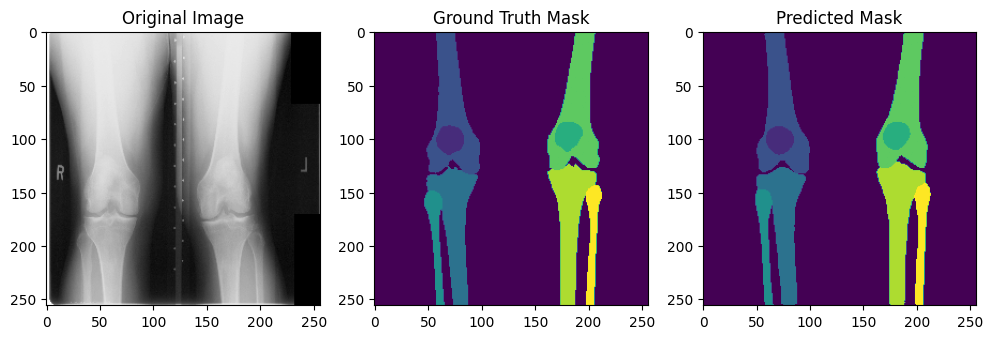

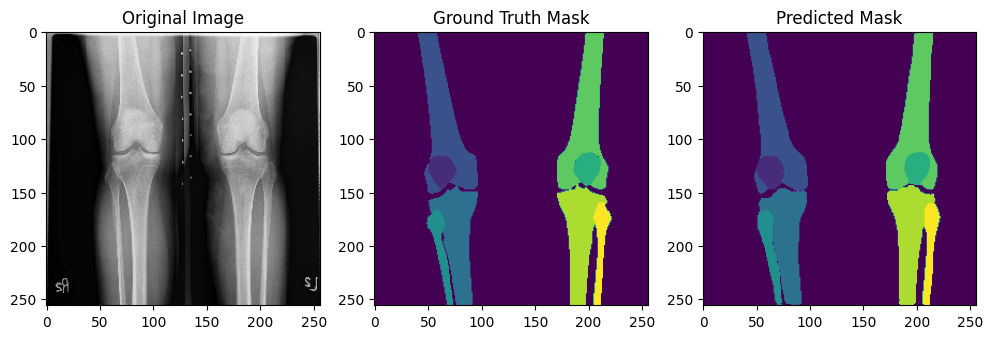

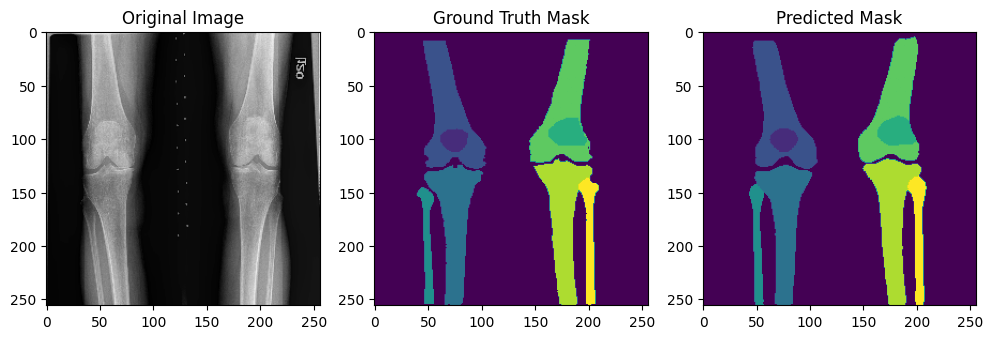

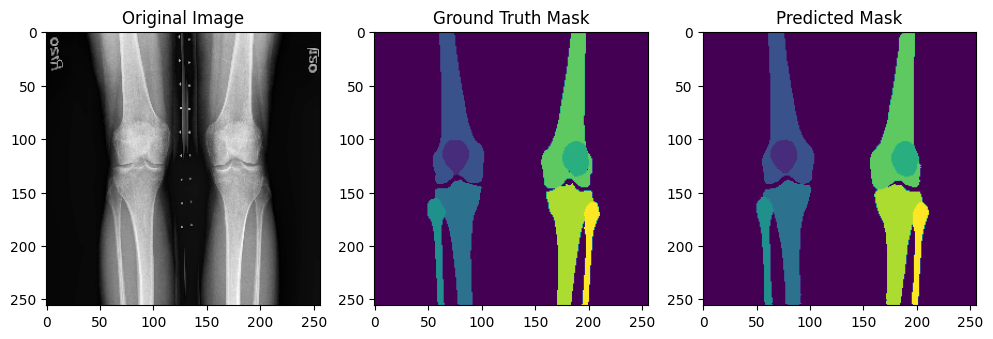

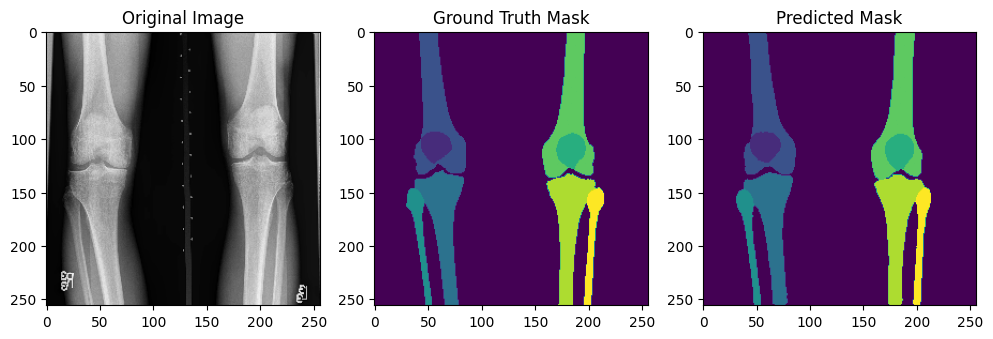

In [ ]:
import matplotlib.pyplot as plt


def visualize_samples(loader, num_samples=5):
    model.eval()
    with torch.no_grad():
        for i, (images, masks, _) in enumerate(loader):
            if i >= 1:
                break

            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            predicted_masks = torch.argmax(outputs, dim=1)

            for j in range(images.shape[0]):
                plt.figure(figsize=(12, 4))


                plt.subplot(1, 3, 1)
                plt.title('Original Image')
                plt.imshow(images[j][0].cpu().numpy(), cmap='gray')


                plt.subplot(1, 3, 2)
                plt.title('Ground Truth Mask')
                plt.imshow(masks[j].argmax(dim=0).cpu().numpy(), cmap='viridis')


                plt.subplot(1, 3, 3)
                plt.title('Predicted Mask')
                plt.imshow(predicted_masks[j].cpu().numpy(), cmap='viridis')

                plt.show()


visualization_loader = DataLoader(valid_set, batch_size=5, shuffle=True, num_workers=2)


visualize_samples(visualization_loader, num_samples=5)

In [ ]:
model.eval()


test_augmentations = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2(),
])


test_set = MulticlassHipSegmentationDataset(
    img_root, mask_root, metadata_df, [p[0] for p in test_pairs], [p[1] for p in test_pairs], num_classes,
    transforms=test_augmentations
)

test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

test_iou_list = []


for batch_idx, (images, masks, race) in enumerate(test_loader):
    images, masks = images.to(device), masks.to(device)


    with torch.no_grad():
        outputs = model(images)


    predicted_masks = torch.argmax(outputs, dim=1)


    test_iou = jaccard_score(
        masks.argmax(dim=1).cpu().numpy().flatten(),
        predicted_masks.cpu().numpy().flatten(),
        average='micro'
    )
    test_iou_list.append(test_iou)


test_iou_avg = np.mean(test_iou_list)


print(f"Test IoU: {test_iou_avg:.4f}")


/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/tmp/ipykernel_2411330/3707542994.py:80: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if r

Test IoU: 0.9661


In [ ]:
saved_model_path = 'trained_model_ KneeMulti Diversity 100 BCL epoch with Decay1e-5 ioulib.pth'


torch.save(model.state_dict(), saved_model_path)


print(f"Model saved to {saved_model_path}")

Model saved to trained_model_ KneeMulti Diversity 100 BCL epoch with Decay1e-5 ioulib.pth
